# ANALYSIS OF OUTER SUBURBS IN COLOMBO CONCERNING LAND PRICES AND DENSITY OF SOCIAL PLACES


Importing required libraries


In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import geocoder
import folium
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.spatial import distance

## Gatehring List of Outer Suburbs and their Geo-Coordinates  

scrapping wikipedia page using BeautifulSoup to get list of outer suburbs around Colombo Sri Lanka

In [18]:
url='https://en.m.wikipedia.org/wiki/Colombo'
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

listSuburbs = []
div = soup.find_all('div', class_='div-col')
for ul in div:
    for li in ul.findAll('li'):
        for a in li:
            title = a.string
            listSuburbs.append(title)
            
suburbs = pd.DataFrame(listSuburbs,columns=['Name'])

print(suburbs.shape)

suburbs.head()

(35, 1)


,Name
0,Angoda
1,Athurugiriya
2,Battaramulla
3,Biyagama
4,Boralesgamuwa


Defining a function to get cordinates for a given suburb

In [7]:
def get_geocordination(city):
    location = geocoder.arcgis('{},  COLOMBO, LK'.format(city))
    lat_lng_coords = location.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude,longitude

suburbs['Latitude'],suburbs['Longitude'] = zip(*suburbs['Name'].apply(get_geocordination))

In [10]:
suburbs.head()

,Name,Latitude,Longitude
0,Angoda,6.935934,79.925654
1,Athurugiriya,6.877397,79.989996
2,Battaramulla,6.902228,79.919574
3,Biyagama,6.946234,79.991284
4,Boralesgamuwa,6.841013,79.901718


Get location of Colombo city center for visualiztion

In [9]:
latitude , longitude = get_geocordination('COLOMBO')

print(latitude)
print(longitude)

6.931940000000054
79.84555000000006


## Generating a map centred around the Colombo

In [11]:
venues_map = folium.Map(location=[latitude, longitude+0.06], zoom_start=12, width=600)

# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Colombo',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(suburbs.Latitude, suburbs.Longitude, suburbs.Name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

## Gathering Average Land Prices and merging into Suburbs Data Frame

scrapping lanka property web page using Pandas library to get list of average land prices

In [16]:
landPricesWEB = pd.read_html('https://www.lankapropertyweb.com/house_prices.php')
landPrices = landPricesWEB[4].rename(columns={'Unnamed: 0': 'Name',
                                              'Average Price (Per Perch)': 'Price'})
landPrices['Price'] = landPrices['Price'].str.replace(r"\(.*\)","").str.replace(",","")
landPrices.head()

,Name,Price
0,Angoda,625972
1,Athurugiriya,484436
2,Bandaragama,197576
3,Battaramulla,1880478
4,Biyagama,521190


Merging land prices into suburbs data frame

In [20]:
suburbs = pd.merge(suburbs, landPrices, on='Name', how='left')
suburbs.head()

,Name,Latitude,Longitude,Price
0,Angoda,6.935934,79.925654,625972
1,Athurugiriya,6.877397,79.989996,484436
2,Battaramulla,6.902228,79.919574,1880478
3,Biyagama,6.946234,79.991284,521190
4,Boralesgamuwa,6.841013,79.901718,1554242


## Data wrangling

Checking is there NULL values in data frame

In [21]:
suburbs.isnull().values.any()

True

Identifieng NULL rows

In [24]:
def nans(df): return df[df.isnull().any(axis=1)]
nans(suburbs)

,Name,Latitude,Longitude,Price
18,Koswatte,6.908071,79.929538,NaN
19,Kotikawatta,6.936024,79.915914,NaN


Defining a function to impute missing land prices using nearest suburb's prices

In [26]:
def imputePrice(Name,k):
    
    a = distance.cdist(suburbs.loc[suburbs['Name'] == Name][['Longitude', 'Latitude']],
                       suburbs[['Longitude', 'Latitude']], 'cityblock')
    ind=([])
    
    for i in range(k):
      ind.append(np.argpartition(a, i+1)[0][i+1])
    
    print('Nearest '+ str(k) +' Suburbs for ' + Name + ' are ')
    print(suburbs.iloc[ind])
    
    average = suburbs.iloc[ind]['Price'].astype(int).mean().astype(int)
    
    print('imputed price : ' + str(average))
    
    return average

Imputing Land Prices for 'KOSWATTA' and 'KOTIKAWATTA' using nearst three suburbs (k = 3)

In [27]:
suburbs.loc[suburbs['Name'] == 'Koswatte', ['Price']] = imputePrice('Koswatte',3)
suburbs.loc[suburbs['Name'] == 'Kotikawatta', ['Price']] = imputePrice('Kotikawatta',3)

Nearest 3 Suburbs for Koswatte are 
            Name  Latitude  Longitude     Price
31     Thalahena  6.908317  79.944762  1800000 
2   Battaramulla  6.902228  79.919574  1880478 
26     Pelawatte  6.891253  79.928900  2035000 
imputed price : 1905159
Nearest 3 Suburbs for Kotikawatta are 
         Name  Latitude  Longitude    Price
0      Angoda  6.935934  79.925654  625972 
14   Kelaniya  6.950025  79.917277  630833 
6   Gothatuwa  6.929570  79.906005  945000 
imputed price : 733935


Dataset without any missing values

In [29]:
suburbs

,Name,Latitude,Longitude,Price
0,Angoda,6.935934,79.925654,625972
1,Athurugiriya,6.877397,79.989996,484436
2,Battaramulla,6.902228,79.919574,1880478
3,Biyagama,6.946234,79.991284,521190
4,Boralesgamuwa,6.841013,79.901718,1554242
5,Dehiwala,6.851325,79.865995,4008277
6,Gothatuwa,6.929570,79.906005,945000
7,Hokandara,6.880341,79.959809,643083
8,Ja-Ela,7.077637,79.891086,447531
9,Homagama,6.841217,80.003118,387284


## Retreiving most common venues using Foursquare API

Defining foursquare API secret keys

In [66]:
CLIENT_ID = 'JVAJQW02IZA3S0PSEZRKFKYKRCQFUVPRQMOUQXUWZPE3TTC' # Changed when publish - this will not work
CLIENT_SECRET = 'GBGDWNUUEVAFGGOLAANN12T1LYOTB5J13HDGE3422E0HN2K' # Changed when publish - this will not work
VERSION = '20200726'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JVAJQW02IZA3S0PSEZRKFKYKRCQFUVPRQMOUQXUWZPE3TTC
CLIENT_SECRET:GBGDWNUUEVAFGGOLAANN12T1LYOTB5J13HDGE3422E0HN2K


Defining a function to retreve nearby venues

In [33]:
def getNearbyVenueswithPrice(suburb, latitudes, longitudes,price, radius=3000, LIMIT=20):
    
    venues_list=[]
    for suburb, lat, lng, price in zip(suburb, latitudes, longitudes,price):
        print(suburb)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            suburb, 
            lat, 
            lng,
            price,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Latitude', 
                  'Longitude',
                  'Price',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Retreiving nearby venues

In [34]:
nearby_venues_w_price = getNearbyVenueswithPrice(suburb=suburbs['Name'],
                                   latitudes=suburbs['Latitude'],
                                   longitudes=suburbs['Longitude'],
                                                 price = suburbs['Price']
                                )

Angoda
Athurugiriya
Battaramulla
Biyagama
Boralesgamuwa
Dehiwala
Gothatuwa
Hokandara
Ja-Ela
Homagama
Kadawatha
Kaduwela
Kalubowila
Kandana
Kelaniya
Kesbewa
Kiribathgoda
Kolonnawa
Koswatte
Kotikawatta
Kottawa
Maharagama
Malabe
Moratuwa
Mount Lavinia
Pannipitiya
Pelawatte
Peliyagoda
Piliyandala
Ragama
Rathmalana
Thalahena
Thalawathugoda
Wattala
Wellampitiya


Checking retreived venue types

In [37]:
print(nearby_venues_w_price.shape)
print(nearby_venues_w_price['Venue Category'].unique())
print('There are {} uniques categories.'.format(len(nearby_venues_w_price['Venue Category'].unique())))

(636, 8)
['Pizza Place' 'Grocery Store' 'Clothing Store' 'Supermarket'
 'Bus Station' 'Aquarium' 'Park' 'Convenience Store'
 'Fast Food Restaurant' 'Bakery' 'Gym' 'Sri Lankan Restaurant' 'Bus Stop'
 'Lake' 'Dessert Shop' 'Coffee Shop' 'Track' 'Food' 'Department Store'
 'Cocktail Bar' 'Bar' 'Playground' 'Restaurant' 'Bookstore'
 'Asian Restaurant' 'Sandwich Place' 'Seafood Restaurant'
 'Japanese Restaurant' 'Boutique' 'Toll Booth' 'Athletics & Sports'
 'Diner' 'Shipping Store' 'Shopping Mall' 'Fair' 'Miscellaneous Shop'
 'Golf Course' 'Airport' "Women's Store" 'Candy Store' 'Beach Bar'
 'Cosmetics Shop' 'Beach' 'IT Services' 'Pub' 'Auto Garage'
 'Chinese Restaurant' 'Italian Restaurant' 'Sports Bar' 'Shopping Plaza'
 'Gym Pool' 'Movie Theater' 'Café' 'Snack Place' 'Platform'
 'Train Station' 'Hotel' 'Intersection' 'Hotel Bar' 'Trail'
 'Gym / Fitness Center' 'College Cafeteria' 'Shop & Service' 'Hostel'
 'Camera Store' 'Juice Bar' 'Indian Restaurant' 'Boarding House' 'Office'
 'Performin

It was identified that some same type venues are categorised in different names. Those types were replaced in single type.

In [38]:
nearby_venues_w_price["Venue Category"].replace({"Light Rail Station": "Train Station", "Platform": "Train Station"}, inplace=True)
nearby_venues_w_price["Venue Category"].replace({"Gym / Fitness Center": "Gym", "Bus Station": "Bus Stop"}, inplace=True)
nearby_venues_w_price["Venue Category"].replace({"Shopping Plaza": "Shopping Mall", "Supermarket": "Shopping Mall", "Metro Station": "Train Station"}, inplace=True)
print('There are {} uniques categories.'.format(len(nearby_venues_w_price['Venue Category'].unique())))

There are 91 uniques categories.


## Analysis


Preparing for clustering by one-hot encoding

In [39]:
# one hot encoding
colombo_onehot = pd.get_dummies(nearby_venues_w_price[['Venue Category']], prefix="", prefix_sep="")

# add Postal Code column back to dataframe
colombo_onehot['Suburb'] = nearby_venues_w_price['Suburb'] 
colombo_onehot['Price'] = nearby_venues_w_price['Price'] 

# move Postal Code column to the first column
fixed_columns = list(colombo_onehot.columns[-2:]) + list(colombo_onehot.columns[:-2])
colombo_onehot = colombo_onehot[fixed_columns]

colombo_onehot.head(5)

,Suburb,Price,Airport,Aquarium,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,...,Tennis Stadium,Theme Park,Thrift / Vintage Store,Toll Booth,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Volleyball Court,Women's Store
0,Angoda,625972,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Angoda,625972,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Angoda,625972,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Angoda,625972,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Angoda,625972,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Changing colume value types (Price was in object value type)

In [40]:
colombo_onehot["Price"] = pd.to_numeric(colombo_onehot["Price"])

Normalizing Data set

In [41]:
nearby_grouped = colombo_onehot.groupby('Suburb').mean().reset_index()
nearby_grouped.head()

,Suburb,Price,Airport,Aquarium,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bank,Bar,...,Tennis Stadium,Theme Park,Thrift / Vintage Store,Toll Booth,Track,Trail,Train Station,Vegetarian / Vegan Restaurant,Volleyball Court,Women's Store
0,Angoda,625972,0.00,0.066667,0.00,0.00,0.0,0.000000,0.0,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,Athurugiriya,484436,0.00,0.000000,0.00,0.00,0.0,0.090909,0.0,0.00,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,Battaramulla,1880478,0.00,0.000000,0.05,0.00,0.0,0.050000,0.0,0.05,...,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
3,Biyagama,521190,0.00,0.000000,0.00,0.00,0.0,0.000000,0.0,0.10,...,0.0,0.0,0.0,0.1,0.00,0.0,0.0,0.0,0.0,0.0
4,Boralesgamuwa,1554242,0.05,0.000000,0.05,0.05,0.0,0.050000,0.0,0.00,...,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0


Identifying optimal K value for K-means algorithm

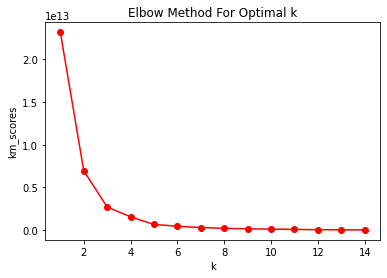

In [42]:
colombo_grouped_clustering = nearby_grouped.drop('Suburb', 1)
Sum_of_squared_distances = []
km_scores= []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(colombo_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'ro-')
plt.xlabel('k')
plt.ylabel('km_scores')
plt.title('Elbow Method For Optimal k')
plt.show()

Applying K-means Algorithm to cluster suburbs (k = 4)

In [43]:
kclusters = 4

colombo_grouped_clustering = nearby_grouped.drop('Suburb', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(colombo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 0, 1, 0, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 0, 1, 1, 3,
       3, 3, 2, 3, 0, 3, 1, 1, 0, 0, 0, 3, 1], dtype=int32)

## Results

Defining a function to get most common location type by suburb

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:] 
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Retriveing first ten most common venue types for list suburbs

In [50]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Suburb'] = nearby_grouped['Suburb']

for ind in np.arange(nearby_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nearby_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Angoda,Bus Stop,Shopping Mall,Grocery Store,Aquarium,Pizza Place,Clothing Store,Convenience Store,Park,Fast Food Restaurant,Women's Store
1,Athurugiriya,Shopping Mall,Bus Stop,Gym,Grocery Store,Pizza Place,Bakery,Sri Lankan Restaurant,Women's Store,Concert Hall,Convenience Store
2,Battaramulla,Fast Food Restaurant,Department Store,Restaurant,Sandwich Place,Seafood Restaurant,Dessert Shop,Japanese Restaurant,Park,Bookstore,Gym
3,Biyagama,Gym,Bar,Restaurant,Bus Stop,Shopping Mall,Boutique,Pizza Place,Toll Booth,Grocery Store,Food
4,Boralesgamuwa,Department Store,Shopping Mall,Pizza Place,Airport,Fast Food Restaurant,Miscellaneous Shop,Shipping Store,Diner,Bookstore,Fair


Merging cluster labels with top venue data

In [51]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

suburbs_merged = suburbs

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
suburbs_merged = suburbs_merged.join(neighborhoods_venues_sorted.set_index('Suburb'), on='Name')

In [54]:
suburbs_merged.head(10)

,Name,Latitude,Longitude,Price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Angoda,6.935934,79.925654,625972,1,Bus Stop,Shopping Mall,Grocery Store,Aquarium,Pizza Place,Clothing Store,Convenience Store,Park,Fast Food Restaurant,Women's Store
1,Athurugiriya,6.877397,79.989996,484436,1,Shopping Mall,Bus Stop,Gym,Grocery Store,Pizza Place,Bakery,Sri Lankan Restaurant,Women's Store,Concert Hall,Convenience Store
2,Battaramulla,6.902228,79.919574,1880478,0,Fast Food Restaurant,Department Store,Restaurant,Sandwich Place,Seafood Restaurant,Dessert Shop,Japanese Restaurant,Park,Bookstore,Gym
3,Biyagama,6.946234,79.991284,521190,1,Gym,Bar,Restaurant,Bus Stop,Shopping Mall,Boutique,Pizza Place,Toll Booth,Grocery Store,Food
4,Boralesgamuwa,6.841013,79.901718,1554242,0,Department Store,Shopping Mall,Pizza Place,Airport,Fast Food Restaurant,Miscellaneous Shop,Shipping Store,Diner,Bookstore,Fair
5,Dehiwala,6.851325,79.865995,4008277,2,Cosmetics Shop,Bakery,Pizza Place,Beach,Women's Store,Shopping Mall,IT Services,Miscellaneous Shop,Department Store,Pub
6,Gothatuwa,6.929570,79.906005,945000,3,Chinese Restaurant,Park,Pizza Place,Cocktail Bar,Clothing Store,Convenience Store,Dessert Shop,Restaurant,Sandwich Place,Seafood Restaurant
7,Hokandara,6.880341,79.959809,643083,1,Shopping Mall,Pizza Place,Gym,Chinese Restaurant,Snack Place,Fast Food Restaurant,Diner,Movie Theater,Convenience Store,Clothing Store
8,Ja-Ela,7.077637,79.891086,447531,1,Clothing Store,Pizza Place,Train Station,Restaurant,Café,Shopping Mall,Department Store,Chinese Restaurant,Bakery,Movie Theater
9,Homagama,6.841217,80.003118,387284,1,Intersection,Clothing Store,Train Station,Bus Stop,Shopping Mall,Hotel,Asian Restaurant,Athletics & Sports,Toll Booth,Grocery Store


Visualising Clusters in Map

In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude+0.06], zoom_start=12, width=600)

rainbow = ['#8000ff', '#000000', '#00ff00', '#ff0000'];

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, price in zip(suburbs_merged['Latitude'], suburbs_merged['Longitude'], suburbs_merged['Name'], suburbs_merged['Cluster Labels'], suburbs_merged['Price']):
    label = folium.Popup(str(poi) + ', Price : ' + str(price) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

## Cluster 1

In [62]:
cluster1 = suburbs_merged.loc[suburbs_merged['Cluster Labels'] == 1, suburbs_merged.columns[[0] + [3] + list(range(5, suburbs_merged.shape[1]))]]
cluster1['Avg Land Price'] = cluster1['Price'].astype(int).mean().round(2)
cluster1

,Name,Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Avg Land Price
0,Angoda,625972,Bus Stop,Shopping Mall,Grocery Store,Aquarium,Pizza Place,Clothing Store,Convenience Store,Park,Fast Food Restaurant,Women's Store,579970.81
1,Athurugiriya,484436,Shopping Mall,Bus Stop,Gym,Grocery Store,Pizza Place,Bakery,Sri Lankan Restaurant,Women's Store,Concert Hall,Convenience Store,579970.81
3,Biyagama,521190,Gym,Bar,Restaurant,Bus Stop,Shopping Mall,Boutique,Pizza Place,Toll Booth,Grocery Store,Food,579970.81
7,Hokandara,643083,Shopping Mall,Pizza Place,Gym,Chinese Restaurant,Snack Place,Fast Food Restaurant,Diner,Movie Theater,Convenience Store,Clothing Store,579970.81
8,Ja-Ela,447531,Clothing Store,Pizza Place,Train Station,Restaurant,Café,Shopping Mall,Department Store,Chinese Restaurant,Bakery,Movie Theater,579970.81
9,Homagama,387284,Intersection,Clothing Store,Train Station,Bus Stop,Shopping Mall,Hotel,Asian Restaurant,Athletics & Sports,Toll Booth,Grocery Store,579970.81
10,Kadawatha,518959,Convenience Store,Restaurant,Bus Stop,Hotel Bar,Shopping Mall,Park,Clothing Store,Gym,Pizza Place,Hotel,579970.81
11,Kaduwela,430000,Asian Restaurant,Bakery,Gym,Shopping Mall,College Cafeteria,Chinese Restaurant,Restaurant,Bus Stop,Shop & Service,Pizza Place,579970.81
13,Kandana,611000,Shopping Mall,Restaurant,Clothing Store,Bakery,Café,Grocery Store,Indian Restaurant,Chinese Restaurant,Department Store,Concert Hall,579970.81
14,Kelaniya,630833,Bakery,Chinese Restaurant,Convenience Store,Bus Stop,Fast Food Restaurant,Pizza Place,Grocery Store,Bookstore,Train Station,Clothing Store,579970.81


## Cluster 2

In [61]:
cluster2 = suburbs_merged.loc[suburbs_merged['Cluster Labels'] == 3, suburbs_merged.columns[[0] + [3] + list(range(5, suburbs_merged.shape[1]))]]
cluster2['Avg Land Price'] = cluster2['Price'].astype(int).mean().round(2)
cluster2

,Name,Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Avg Land Price
6,Gothatuwa,945000,Chinese Restaurant,Park,Pizza Place,Cocktail Bar,Clothing Store,Convenience Store,Dessert Shop,Restaurant,Sandwich Place,Seafood Restaurant,1065355.33
16,Kiribathgoda,918511,Shopping Mall,Fast Food Restaurant,Bakery,Pizza Place,Hotel Bar,Bookstore,Juice Bar,Convenience Store,Restaurant,Clothing Store,1065355.33
17,Kolonnawa,945000,Hotel,Gym,Shopping Mall,IT Services,Flower Shop,Donut Shop,Department Store,Cricket Ground,Office,Park,1065355.33
21,Maharagama,1296439,Shopping Mall,Department Store,Bakery,Fast Food Restaurant,Shipping Store,Burger Joint,Boutique,Bookstore,Recording Studio,Gym,1065355.33
22,Malabe,976897,Fast Food Restaurant,Convenience Store,Shopping Mall,Pizza Place,Grocery Store,College Cafeteria,Gym,Clothing Store,Chinese Restaurant,Movie Theater,1065355.33
23,Moratuwa,961883,Chinese Restaurant,Shopping Mall,Resort,Restaurant,Juice Bar,Bar,Clothing Store,Bus Stop,Sri Lankan Restaurant,Pizza Place,1065355.33
25,Pannipitiya,1101119,Shopping Mall,Convenience Store,Chinese Restaurant,Boutique,Pizza Place,Vegetarian / Vegan Restaurant,Bakery,Ice Cream Shop,Bar,Pub,1065355.33
27,Peliyagoda,1318333,Fast Food Restaurant,Clothing Store,Restaurant,Hotel Bar,Coffee Shop,Gym,Chinese Restaurant,Office,Cricket Ground,Pizza Place,1065355.33
33,Wattala,1125016,Clothing Store,Shopping Mall,Restaurant,Fast Food Restaurant,Bakery,Food,Comfort Food Restaurant,Pizza Place,Pool Hall,Hotel Bar,1065355.33


## Cluster 3

In [64]:
cluster3 = suburbs_merged.loc[suburbs_merged['Cluster Labels'] == 0, suburbs_merged.columns[[0] + [3] + list(range(5, suburbs_merged.shape[1]))]]
cluster3['Avg Land Price'] = cluster3['Price'].astype(int).mean().round(2)
cluster3

,Name,Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Avg Land Price
2,Battaramulla,1880478,Fast Food Restaurant,Department Store,Restaurant,Sandwich Place,Seafood Restaurant,Dessert Shop,Japanese Restaurant,Park,Bookstore,Gym,1845639.43
4,Boralesgamuwa,1554242,Department Store,Shopping Mall,Pizza Place,Airport,Fast Food Restaurant,Miscellaneous Shop,Shipping Store,Diner,Bookstore,Fair,1845639.43
18,Koswatte,1905159,Bakery,Fast Food Restaurant,Grocery Store,Bookstore,Playground,Coffee Shop,Cocktail Bar,Department Store,Restaurant,Sandwich Place,1845639.43
26,Pelawatte,2035000,Gym,Bakery,Chinese Restaurant,Sports Bar,Park,Playground,Racetrack,Lake,Juice Bar,Dessert Shop,1845639.43
30,Rathmalana,2002602,Bakery,Clothing Store,Airport,Shopping Mall,Hotel,Fast Food Restaurant,Mediterranean Restaurant,Convenience Store,Movie Theater,Pizza Place,1845639.43
31,Thalahena,1800000,Bakery,Convenience Store,Chinese Restaurant,Racetrack,Shopping Mall,IT Services,Food,Indian Restaurant,Fast Food Restaurant,Juice Bar,1845639.43
32,Thalawathugoda,1741995,Gym,Shopping Mall,Gym Pool,Sports Bar,Playground,Chinese Restaurant,Convenience Store,Café,Restaurant,Juice Bar,1845639.43


## Cluster 4

In [65]:
cluster4 = suburbs_merged.loc[suburbs_merged['Cluster Labels'] == 2, suburbs_merged.columns[[0] + [3] + list(range(5, suburbs_merged.shape[1]))]]
cluster4['Avg Land Price'] = cluster4['Price'].astype(int).mean().round(2)
cluster4

,Name,Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Avg Land Price
5,Dehiwala,4008277,Cosmetics Shop,Bakery,Pizza Place,Beach,Women's Store,Shopping Mall,IT Services,Miscellaneous Shop,Department Store,Pub,3235008.0
12,Kalubowila,3061111,Bakery,Women's Store,Bookstore,Office,Coffee Shop,Miscellaneous Shop,Camera Store,Café,Sandwich Place,Juice Bar,3235008.0
24,Mount Lavinia,2635636,Bakery,Restaurant,Pub,Clothing Store,Shopping Mall,Beach,Mediterranean Restaurant,Candy Store,Fast Food Restaurant,Bar,3235008.0
